# Experiments in Modeling Issue Segmentation

### Load Libraries and Datasets

In [1]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
import numpy as np

console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file

In [2]:
full_df = read_csv_file("../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038071/mdp_39015056038071_annotated_individual_tokens.csv")
console.print(f"Dataframe is this size: {len(full_df)}")
console.print(f"Dataframe has this many issues: {full_df.start_issue.nunique()}")
console.print(f"Dataframe has this many pages: {full_df.page_number.nunique()}")
# Factorize the 'issue_number' column to create 'actual_issue_number'
full_df = full_df.sort_values(by=['page_number'])
full_df = full_df.rename(columns={'issue_number': 'original_issue_number'})
full_df['temp_issue_number'] = pd.factorize(full_df['original_issue_number'])[0]

Dataframe is this size: 300791

Dataframe has this many issues: 26

Dataframe has this many pages: 907

### Clean and Visualize Page Numbers

In [3]:
def filter_integers(token: str) -> bool:
	"""Check if the token is an integer."""
	return bool(re.match(r'^\d+$', token))

def clean_digits(df: pd.DataFrame) -> pd.DataFrame:
	"""Clean and filter digit tokens in the DataFrame while retaining non-digit pages."""
	max_page = df.page_number.max()
	
	df['token'] = df['token'].astype(str)
	if 'volume_name' in df.columns:
		df['volume_number'] = df['volume_number'].fillna(0)
	
	# Identify pages with digit tokens
	subset_digits = df[df['token'].str.isdigit()].copy()
	possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()
	non_digits_pages = df[(~df['token'].str.isdigit()) & (~df.page_number.isin(subset_digits.page_number))].copy()
	# just take the first page of non_digits_pages
	non_digits_pages = non_digits_pages.groupby('page_number').first().reset_index()
	
	# Use the smaller subset if possible_pages is smaller
	if len(possible_pages) < len(subset_digits):
		subset_digits = possible_pages
	
	console.print(f"Number of digits in this volume: {len(subset_digits)}")
	console.print(f"Number of non-digit pages in this volume: {len(non_digits_pages)}")
	
	subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
	max_possible_number = max_page + 25
	filtered_subset_digits = subset_digits[subset_digits['number'] < max_possible_number]
	non_filtered_subset_digits = subset_digits[(subset_digits['number'] >= max_possible_number) & (~subset_digits.page_number.isin(filtered_subset_digits.page_number))].groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume after filtering for max page length: {len(filtered_subset_digits)}")
	console.print(f"Number of pages without digits in this volume after filtering for max page length: {len(non_filtered_subset_digits)}")
	
	# Calculate implied zero only for digit pages
	filtered_subset_digits['implied_zero'] = filtered_subset_digits['page_number'].astype(int) - filtered_subset_digits['number']
	
	final_subset_digits = filtered_subset_digits[filtered_subset_digits['implied_zero'] >= 0]
	console.print(f"Number of digits in this volume after filtering for max page length and implied zero: {len(final_subset_digits)}")
	remaining_missing_pages = df[(~df.page_number.isin(final_subset_digits.page_number)) & (~df.page_number.isin(non_digits_pages.page_number))].copy()
	remaining_missing_pages = remaining_missing_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of pages without digits in this volume after filtering for max page length and digit pages: {len(remaining_missing_pages)}")
	
	# Merge non-digit pages back into the DataFrame
	non_digits_pages['page_type'] = 'non_digit'
	remaining_missing_pages['page_type'] = 'negative_digit'
	final_subset_digits['page_type'] = 'digit'
	non_filtered_subset_digits['page_type'] = 'digit_too_large'
	full_df_with_digits = pd.concat([final_subset_digits, non_digits_pages, remaining_missing_pages, non_filtered_subset_digits]).sort_values(by=['page_number']).reset_index(drop=True)
	
	console.print(f"Number of pages after including non-digit pages: {full_df_with_digits.page_number.nunique()}")

	if full_df_with_digits.page_number.nunique() != full_df.page_number.nunique():
		added_pages = full_df[~full_df.page_number.isin(full_df_with_digits.page_number)].copy()
		added_pages = added_pages.groupby('page_number').first().reset_index()
		added_pages['page_type'] = 'added'
		full_df_with_digits = pd.concat([full_df_with_digits, added_pages]).sort_values(by=['page_number']).reset_index(drop=True)
		console.print(f"Number of pages after including added pages: {full_df_with_digits.page_number.nunique()}")
	
	return full_df_with_digits

# Example usage
subset_digits = clean_digits(full_df)
console.print(f"Which gives us this many potential digit candidates per issue: {subset_digits.start_issue.value_counts()}. Though the number of digits per issue is only known for annotated issues.")
console.print(f"Here are counts per digits: {subset_digits.implied_zero.value_counts()}")

Number of digits in this volume: 6885

Number of non-digit pages in this volume: 97

Number of digits in this volume after filtering for max page length: 5299

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 4923

Number of pages without digits in this volume after filtering for max page length and digit pages: 24

Number of pages after including non-digit pages: 907

Which gives us this many potential digit candidates per issue: start_issue
1962-05-14    253
1962-04-16    238
1962-04-23    235
1962-03-26    229
1962-04-02    228
1962-01-08    222
1962-03-19    220
1962-05-28    220
1962-05-21    219
1962-06-25    219
1962-03-12    214
1962-04-30    214
1962-06-18    203
1962-03-05    200
1962-02-26    200
1962-02-12    189
1962-02-19    179
1962-06-11    176
1962-02-05    173
1962-04-09    172
1962-05-07    170
1962-06-04    169
1962-01-22    152
1962-01-29    148
1962-01-15    130
1962-01-01     93
Name: count, dtype: int64. Though the number of digits per issue is only known for annotated issues.

Here are counts per digits: implied_zero
224.0    25
260.0    25
908.0    24
872.0    24
188.0    22
         ..
794.0     1
791.0     1
790.0     1
106.0     1
944.0     1
Name: count, Length: 934, dtype: int64

In [4]:
# def detect_issue_boundaries(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
#     """Detect issue boundaries in the dataset using a sliding window approach, while retaining non-digit pages.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing page numbers and implied zeros.
#         window_size (int): The size of the sliding window.
#         threshold_sizes (list): A list of threshold sizes to detect boundaries.

#     Returns:
#         pd.DataFrame: A DataFrame containing detected boundaries.
#     """
#     # Prepare the DataFrame by ensuring necessary columns are integers
#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    
#     # Sort by page_number for sequential window analysis
#     df = df.sort_values(by=['page_number'])
    
#     # Initialize list to store detected boundaries across all thresholds
#     all_boundaries = []
    
#     for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
#         # Initialize deque to maintain a sliding window of page numbers for each threshold
#         sliding_window = deque(maxlen=window_size)
        
#         # Initialize list to store detected boundaries for this threshold
#         issue_boundaries = []
#         issue_number = 0
#         existing_start_issue = None
        
#         page_numbers = df['page_number'].unique().tolist()
        
#         for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
#             selected_rows = df[(df['page_number'] == page_number)]
#             implied_zero_values = selected_rows[(selected_rows.implied_zero.notna()) & (selected_rows.page_type == "digit")]['implied_zero'].tolist()
#             is_digit_page = selected_rows['page_type'].values[0]
            
#             if index == 0:
#                 existing_start_issue = selected_rows['start_issue'].values[0]
            
#             # Update the sliding window with each unique page and its implied zeros, including non-digit pages
#             if is_digit_page == "digit":
#                 for implied_zero in implied_zero_values:
#                     sliding_window.append((page_number, implied_zero))
#             else:
#                 sliding_window.append((page_number, None))  # Use None for non-digit pages
            
#             # Check for boundary conditions only if window is full
#             if len(sliding_window) == window_size:
#                 page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
#                 implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)
                
#                 # If the page range or implied zero diff exceeds the threshold, flag a potential boundary
#                 if page_range > threshold or implied_zero_diff > threshold:
#                     issue_boundaries.append((page_number, implied_zero_values, 'potential_boundary', selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0], is_digit_page))
            
#             # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
#             if existing_start_issue != selected_rows['start_issue'].values[0]:
#                 issue_number += 1
#                 existing_start_issue = selected_rows['start_issue'].values[0]
        
#         # Append results for this threshold to all boundaries outside of page loop
#         all_boundaries.extend(issue_boundaries)
    
#     # Create DataFrame for all boundaries with threshold as a column
#     boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number', 'page_type'])
#     return boundaries_df

# # Example usage with multiple threshold sizes
# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
# boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=range_of_max_issue_length)

# # Display results
# console.print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {len(boundaries_df.threshold.unique())}")

In [6]:
def probabilistic_issue_detection(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
    """Detect issue boundaries probabilistically without relying on annotations."""

    df['page_number'] = df['page_number'].astype(int)
    df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    df = df.sort_values(by=['page_number'])

    # Initialize list to store detected boundaries across all thresholds
    all_boundaries = []

    for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
        # Initialize deque to maintain a sliding window of page numbers for each threshold
        sliding_window = deque(maxlen=window_size)
        # Initialize list to store detected boundaries for this threshold
        issue_boundaries = []
        issue_number = 0
        existing_start_issue = None

        page_numbers = df['page_number'].unique().tolist()
        for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
            selected_rows = df[df['page_number'] == page_number]
            implied_zero_values = selected_rows[(selected_rows.implied_zero.notna()) & (selected_rows.page_type == "digit")]['implied_zero'].tolist()
            is_digit_page = selected_rows['page_type'].values[0]

            if index == 0:
                existing_start_issue = selected_rows['start_issue'].values[0]

            # Update the sliding window
            if is_digit_page == "digit":
                for implied_zero in implied_zero_values:
                    sliding_window.append((page_number, implied_zero))
            else:
                sliding_window.append((page_number, None))

            # Check boundaries when window is full
            if len(sliding_window) == window_size:
                page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
                implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)

                # Probabilistic scoring for boundary detection
                score = 0
                if page_range > threshold:
                    score += 0.5
                    # If the page range exceeds the threshold, add to score by 0.5. 

                if implied_zero_diff > threshold:
                    score += 0.5
                    # If the implied zero difference exceeds the threshold, add to score by 0.5.

                # Check if non-digit pages contribute to score
                non_digit_count = sum(1 for p in sliding_window if p[1] is None)
                if non_digit_count > 0:
                    score += 0.2 * (non_digit_count / window_size)
                    # If non-digit pages are present, add to score by 0.2 for each non-digit page.

                # Flag boundary if score is sufficient
                if score > 0:
                    issue_boundaries.append((
                        page_number, implied_zero_values, 'potential_boundary',
                        selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0], is_digit_page
                    ))

            # Increment issue_number for a new start_issue
            if existing_start_issue != selected_rows['start_issue'].values[0]:
                issue_number += 1
                existing_start_issue = selected_rows['start_issue'].values[0]

        # Print summary after each threshold
        console.print(f"Total boundaries detected at threshold {threshold}: {len(issue_boundaries)}")
        all_boundaries.extend(issue_boundaries)

    # Create DataFrame for all boundaries
    boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number', 'page_type'])

    # Calculate probabilistic weights for each threshold
    boundaries_df['boundary_prob'] = boundaries_df.groupby('threshold')['page_number'].transform('count') / len(df['page_number'].unique())

    return boundaries_df

# Example usage with a more focused range of thresholds
range_of_max_issue_length = [20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
boundaries_df = probabilistic_issue_detection(subset_digits, threshold_sizes=range_of_max_issue_length)

# Analyze results
console.print(f"Detected {len(boundaries_df)} potential boundaries across {len(boundaries_df.threshold.unique())} thresholds.")



Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1747.78it/s]


Boundary detected at page 313 with score 0.5 and threshold 30
Total boundaries detected at threshold 20: 761

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1528.20it/s]


Total boundaries detected at threshold 25: 682

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1701.81it/s]


Total boundaries detected at threshold 30: 601

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1539.04it/s]


Total boundaries detected at threshold 35: 576

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1746.47it/s]


Total boundaries detected at threshold 40: 544

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1554.67it/s]


Total boundaries detected at threshold 45: 528

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1733.90it/s]


Total boundaries detected at threshold 50: 511

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1589.36it/s]


Total boundaries detected at threshold 55: 500

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1698.97it/s]


Total boundaries detected at threshold 60: 488

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1569.43it/s]


Total boundaries detected at threshold 70: 460

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1844.49it/s]


Total boundaries detected at threshold 80: 434

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1263.54it/s]


Total boundaries detected at threshold 90: 411

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1174.61it/s]


Total boundaries detected at threshold 100: 387

Threshold Sizes: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Detected 6883 potential boundaries across 13 thresholds.

In [10]:
def updated_probabilistic_issue_detection(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30], score_threshold: float = 0.5) -> pd.DataFrame:
    """Detect issue boundaries probabilistically without relying on annotations."""

    df['page_number'] = df['page_number'].astype(int)
    df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    df = df.sort_values(by=['page_number'])

    # Initialize list to store detected boundaries across all thresholds
    all_boundaries = []

    for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
        sliding_window = deque(maxlen=window_size)
        issue_boundaries = []
        issue_number = 0
        existing_start_issue = None

        page_numbers = df['page_number'].unique().tolist()
        cumulative_score = 0  # Use cumulative scoring

        for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
            selected_rows = df[df['page_number'] == page_number]
            implied_zero_values = selected_rows[(selected_rows.implied_zero.notna()) & (selected_rows.page_type == "digit")]['implied_zero'].tolist()
            is_digit_page = selected_rows['page_type'].values[0]

            if index == 0:
                existing_start_issue = selected_rows['start_issue'].values[0]

            # Update the sliding window
            if is_digit_page == "digit":
                for implied_zero in implied_zero_values:
                    sliding_window.append((page_number, implied_zero))
            else:
                sliding_window.append((page_number, None))

            # Check boundaries when window is full
            if len(sliding_window) == window_size:
                page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
                implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)

                # Adjust weights for boundary detection
                score = 0
                if page_range > threshold:
                    score += 0.6  # Increased weight for page range
                    # console.print(f"Page {page_number}: Page range {page_range} exceeds threshold {threshold}, score now {score}")

                if implied_zero_diff > threshold:
                    score += 0.4  # Increased weight for implied zero diff
                    # console.print(f"Page {page_number}: Implied zero diff {implied_zero_diff} exceeds threshold {threshold}, score now {score}")

                # Increase weight of non-digit pages in the score
                non_digit_count = sum(1 for p in sliding_window if p[1] is None)
                if non_digit_count > 0:
                    score += 0.3 * (non_digit_count / window_size)  # Increase weight for non-digit pages
                    # console.print(f"Page {page_number}: Non-digit count {non_digit_count}, score now {score}")

                # Use cumulative scoring
                cumulative_score += score

                # Flag boundary if cumulative score is sufficient
                if cumulative_score >= score_threshold:
                    # console.print(f"Boundary detected at page {page_number} with cumulative score {cumulative_score} and threshold {score_threshold}")
                    issue_boundaries.append((
                        page_number, implied_zero_values, 'potential_boundary',
                        selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0], is_digit_page
                    ))
                    cumulative_score = 0  # Reset cumulative score after detecting a boundary
                # else:
                #     console.print(f"No boundary detected at page {page_number}, cumulative score was {cumulative_score}")

            # Increment issue_number for a new start_issue
            if existing_start_issue != selected_rows['start_issue'].values[0]:
                issue_number += 1
                existing_start_issue = selected_rows['start_issue'].values[0]

        # Print summary after each threshold
        console.print(f"Total boundaries detected at threshold {threshold}: {len(issue_boundaries)}")
        all_boundaries.extend(issue_boundaries)

    # Create DataFrame for all boundaries
    boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number', 'page_type'])

    # Calculate probabilistic weights for each threshold
    boundaries_df['boundary_prob'] = boundaries_df.groupby('threshold')['page_number'].transform('count') / len(df['page_number'].unique())

    return boundaries_df

# Example usage with adjusted score threshold and weighting
range_of_max_issue_length = [20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
updated_boundaries_df = updated_probabilistic_issue_detection(subset_digits, threshold_sizes=range_of_max_issue_length, score_threshold=0.5)

# Analyze results
console.print(f"Detected {len(updated_boundaries_df)} potential boundaries across {len(updated_boundaries_df.threshold.unique())} thresholds.")

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1707.79it/s]


Total boundaries detected at threshold 20: 378

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1559.86it/s]


Total boundaries detected at threshold 25: 332

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1856.97it/s]


Total boundaries detected at threshold 30: 285

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1662.52it/s]


Total boundaries detected at threshold 35: 261

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1876.15it/s]


Total boundaries detected at threshold 40: 244

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1691.95it/s]


Total boundaries detected at threshold 45: 236

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1782.83it/s]


Total boundaries detected at threshold 50: 224

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1839.28it/s]


Total boundaries detected at threshold 55: 217

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1554.61it/s]


Total boundaries detected at threshold 60: 210

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1877.19it/s]


Total boundaries detected at threshold 70: 194

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1626.34it/s]


Total boundaries detected at threshold 80: 178

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1874.89it/s]


Total boundaries detected at threshold 90: 159

Page Numbers: 100%|██████████| 907/907 [00:00<00:00, 1572.96it/s]


Total boundaries detected at threshold 100: 139

Threshold Sizes: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Detected 3057 potential boundaries across 13 thresholds.

In [16]:
updated_boundaries_df.groupby(['page_number']).boundary_prob.mean()

page_number
26     0.259266
30     0.416759
32     0.391400
34     0.416759
35     0.366042
         ...   
940    0.416759
941    0.340132
942    0.352260
947    0.340132
962    0.352260
Name: boundary_prob, Length: 634, dtype: float64

In [ ]:
updated_boundaries_df.groupby(['status_issue_number', 'threshold']).boundary_prob.mean().reset_index()

In [12]:
# Calculate average boundary probability across status_issue_number and threshold
avg_boundary_prob_df = updated_boundaries_df.groupby(['status_issue_number', 'threshold']).boundary_prob.mean().reset_index()

# Add a likelihood column that represents the probability of a boundary for each issue
avg_boundary_prob_df = avg_boundary_prob_df.rename(columns={'boundary_prob': 'avg_boundary_prob'})
avg_boundary_prob_df['likelihood'] = avg_boundary_prob_df['avg_boundary_prob']


# Display the average boundary probabilities
console.print(avg_boundary_prob_df)

# Visualize the likelihood distribution across thresholds and status_issue_number
chart = alt.Chart(avg_boundary_prob_df).mark_line(point=True).encode(
    x='status_issue_number:O',
    y='likelihood:Q',
    color='threshold:N',
    tooltip=['status_issue_number', 'threshold', 'likelihood']
).properties(
    title='Average Boundary Probability Across Status Issue Number and Threshold'
)

chart

status_issue_number  threshold  avg_boundary_prob  likelihood
0                      0         20           0.416759    0.416759
1                      0         25           0.366042    0.366042
2                      0         30           0.314223    0.314223
3                      0         35           0.287762    0.287762
4                      0         40           0.269019    0.269019
..                   ...        ...                ...         ...
333                   25         60           0.231533    0.231533
334                   25         70           0.213892    0.213892
335                   25         80           0.196251    0.196251
336                   25         90           0.175303    0.175303
337                   25        100           0.153252    0.153252

[338 rows x 4 columns]

alt.Chart(...)

In [7]:
# Visualization
chart = alt.Chart(boundaries_df).mark_point(filled=True).encode(
    x='page_number:Q',
    y='boundary_prob:Q',
    color='threshold:N',
    tooltip=['page_number', 'threshold', 'boundary_prob']
).properties(
    title='Probabilistic Detection of Issue Boundaries'
)

chart

alt.Chart(...)

In [12]:
# def detect_issue_boundaries(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
#     """Detect issue boundaries in the dataset using a sliding window approach, while retaining non-digit pages.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing page numbers and implied zeros.
#         window_size (int): The size of the sliding window.
#         threshold_sizes (list): A list of threshold sizes to detect boundaries.

#     Returns:
#         pd.DataFrame: A DataFrame containing detected boundaries.
#     """
#     # Prepare the DataFrame by ensuring necessary columns are integers
#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int, errors='ignore')
    
#     # Sort by page_number for sequential window analysis
#     df = df.sort_values(by=['page_number'])
    
#     # Initialize list to store detected boundaries across all thresholds
#     all_boundaries = []
    
#     for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
#         # Initialize deque to maintain a sliding window of page numbers for each threshold
#         sliding_window = deque(maxlen=window_size)
        
#         # Initialize list to store detected boundaries for this threshold
#         issue_boundaries = []
#         issue_number = 0
#         existing_start_issue = None
        
#         page_numbers = df['page_number'].unique().tolist()
        
#         for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
#             selected_rows = df[df['page_number'] == page_number]
#             implied_zero_values = selected_rows['implied_zero'].tolist()
#             print('implied_zero_values', implied_zero_values)
#             is_digit_page = selected_rows['is_digit_page'].values[0]
#             print('is_digit_page', is_digit_page)
            
#             if index == 0:
#                 existing_start_issue = selected_rows['start_issue'].values[0]
            
#             # Update the sliding window with each unique page and its implied zeros, including non-digit pages
#             if is_digit_page:
#                 for implied_zero in implied_zero_values:
#                     sliding_window.append((page_number, implied_zero))
#             else:
#                 sliding_window.append((page_number, None))  # Use None for non-digit pages
            
#             # Check for boundary conditions only if window is full
#             if len(sliding_window) == window_size:
#                 print(sliding_window)
#                 page_range = max(p[0] for p in sliding_window if p[1] is not None) - min(p[0] for p in sliding_window if p[1] is not None)
#                 implied_zero_diff = max(p[1] for p in sliding_window if p[1] is not None) - min(p[1] for p in sliding_window if p[1] is not None)


#                 # If the page range or implied zero diff exceeds the threshold, flag a potential boundary
#                 if page_range > threshold or implied_zero_diff > threshold:
#                     issue_boundaries.append((page_number, implied_zero_values, 'potential_boundary', selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0]))
            
#             # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
#             if existing_start_issue != selected_rows['start_issue'].values[0]:
#                 issue_number += 1
#                 existing_start_issue = selected_rows['start_issue'].values[0]
        
#         # Append results for this threshold to all boundaries outside of page loop
#         all_boundaries.extend(issue_boundaries)
    
#     # Create DataFrame for all boundaries with threshold as a column
#     boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number'])
#     return boundaries_df

# # Example usage with multiple threshold sizes
# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
# boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=range_of_max_issue_length)

# # Display results
# console.print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {len(boundaries_df.threshold.unique())}")

In [13]:
# def detect_issue_boundaries(df: pd.DataFrame, window_size: int = 5, threshold_sizes: list = [30]) -> pd.DataFrame:
#     """Detect issue boundaries in the dataset using a sliding window approach.

#     Args:
#         df (pd.DataFrame): The input DataFrame containing page numbers and implied zeros.
#         window_size (int): The size of the sliding window.
#         threshold_sizes (list): A list of threshold sizes to detect boundaries.

#     Returns:
#         pd.DataFrame: A DataFrame containing detected boundaries.
#     """
#     # Prepare the DataFrame by ensuring necessary columns are integers
#     df['page_number'] = df['page_number'].astype(int)
#     df['implied_zero'] = df['implied_zero'].astype(int)
    
#     # Sort by page_number for sequential window analysis
#     df = df.sort_values(by=['page_number'])
    
#     # Initialize list to store detected boundaries across all thresholds
#     all_boundaries = []
    
#     for threshold in tqdm(threshold_sizes, desc="Threshold Sizes"):
#         # Initialize deque to maintain a sliding window of page numbers for each threshold
#         sliding_window = deque(maxlen=window_size)
        
#         # Initialize list to store detected boundaries for this threshold
#         issue_boundaries = []
#         issue_number = 0
#         existing_start_issue = None
        
#         page_numbers = df['page_number'].unique().tolist()
        
#         for index, page_number in tqdm(enumerate(page_numbers), desc="Page Numbers", total=len(page_numbers)):
#             selected_rows = df[df['page_number'] == page_number]
#             implied_zero_values = selected_rows['implied_zero'].tolist()
            
#             if index == 0:
#                 existing_start_issue = selected_rows['start_issue'].values[0]
            
#             # Update the sliding window with each unique page and its implied zeros
#             for implied_zero in implied_zero_values:
#                 sliding_window.append((page_number, implied_zero))
                
#             # Check for boundary conditions only if window is full
#             if len(sliding_window) == window_size:
#                 print(sliding_window)
#                 page_range = max(p[0] for p in sliding_window) - min(p[0] for p in sliding_window)
#                 implied_zero_diff = max(p[1] for p in sliding_window) - min(p[1] for p in sliding_window)
                
#                 if page_range > threshold or implied_zero_diff > threshold:
#                     # Append only once per page with existing page details and current threshold
#                     issue_boundaries.append((page_number, implied_zero_values, 'potential_boundary', selected_rows['start_issue'].values[0], issue_number, threshold, selected_rows['temp_issue_number'].values[0]))
            
#             # Only increment issue_number when a new start_issue is encountered and not the same as the existing one
#             if existing_start_issue != selected_rows['start_issue'].values[0]:
#                 issue_number += 1
#                 existing_start_issue = selected_rows['start_issue'].values[0]
        
#         # Append results for this threshold to all boundaries outside of page loop
#         all_boundaries.extend(issue_boundaries)
    
#     # Create DataFrame for all boundaries with threshold as a column
#     boundaries_df = pd.DataFrame(all_boundaries, columns=['page_number', 'implied_zero_values', 'status', 'start_issue', 'status_issue_number', 'threshold', 'temp_issue_number'])
#     return boundaries_df

# # Example usage with multiple threshold sizes
# range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
# subset_digits = subset_digits.sort_values(by=['page_number'])
# boundaries_df = detect_issue_boundaries(subset_digits, threshold_sizes=range_of_max_issue_length)

# # Display results
# print(f"Detected this many potential boundaries: {len(boundaries_df)} across this many thresholds: {len(boundaries_df.threshold.unique())}")
# print("Detected potential boundaries per threshold:\n", boundaries_df.groupby(['threshold']).size())

In [14]:
correspondence_df = boundaries_df.groupby(['threshold', 'start_issue']).apply(
    lambda x: (x['status_issue_number'] == x['temp_issue_number']).mean()
).reset_index(name='correspondence')

chart = alt.Chart(correspondence_df).mark_point(filled=True).encode(
    x='start_issue:T',
    y='correspondence:Q',
	color='threshold:N',
    tooltip=['threshold', 'correspondence', 'start_issue:T']
).properties(
    title='Correspondence between status_issue_number and temp_issue_number by Threshold'
)

chart

alt.Chart(...)

In [15]:
# Calculate mean, standard deviation, variance, and coefficient of variation
stats_df = correspondence_df.groupby('threshold').correspondence.aggregate(
    mean='mean',
    std='std',
    var='var',
    cv=lambda x: x.std() / x.mean()
).reset_index()

stats_df

,threshold,mean,std,var,cv
0,10,0.975753,0.012131,0.000147,0.012433
1,15,0.974127,0.013173,0.000174,0.013523
2,20,0.970759,0.014930,0.000223,0.015380
3,25,0.966044,0.017822,0.000318,0.018448
4,30,0.961966,0.022943,0.000526,0.023850
5,35,0.966787,0.026309,0.000692,0.027213
6,40,0.965104,0.027755,0.000770,0.028758
7,45,0.963586,0.029049,0.000844,0.030147
8,50,0.960842,0.031825,0.001013,0.033122
9,60,0.954948,0.036542,0.001335,0.038266


In [22]:
import pyperclip
output = subset_digits.groupby(['start_issue']).page_number.nunique().reset_index().sort_values(by=['page_number'], ascending=False)

output = output.rename(columns={'page_number': 'page_count'})
pyperclip.copy(str(output.to_dict(orient='records')))

In [16]:
boundaries_df[boundaries_df.threshold == 200].sort_values(by=['page_number'])

,page_number,implied_zero_values,status,start_issue,status_issue_number,threshold,temp_issue_number,page_type
6559,287,"[168.0, 269.0, 137.0, 217.0, 272.0, 273.0, 261...",potential_boundary,1962-02-19,7,200,7,digit
6560,312,"[224.0, 310.0, 276.0, 291.0, 287.0, 310.0, 297...",potential_boundary,1962-02-26,8,200,8,digit
6561,313,"[287.0, 296.0]",potential_boundary,1962-02-26,8,200,8,digit
6562,354,"[340.0, 119.0, 332.0, 260.0, 326.0]",potential_boundary,1962-03-05,9,200,9,digit
6563,358,"[348.0, 277.0, 271.0, 270.0, 284.0, 352.0, 316...",potential_boundary,1962-03-05,9,200,9,digit
...,...,...,...,...,...,...,...,...
6660,930,"[921.0, 905.0, 927.0, 872.0, 830.0, 908.0, 929...",potential_boundary,1962-06-25,25,200,25,digit
6661,932,"[904.0, 232.0, 909.0]",potential_boundary,1962-06-25,25,200,25,digit
6662,934,"[867.0, 920.0, 909.0, 784.0, 933.0, 534.0, 908.0]",potential_boundary,1962-06-25,25,200,25,digit
6663,935,"[924.0, 923.0, 801.0, 929.0, 895.0, 535.0, 927...",potential_boundary,1962-06-25,25,200,25,digit


In [17]:
boundaries_df

,page_number,implied_zero_values,status,start_issue,status_issue_number,threshold,temp_issue_number,page_type
0,13,"[12.0, 0.0, 11.0, 10.0, 8.0]",potential_boundary,1962-01-01,0,10,0,digit
1,14,"[13.0, 1.0, 9.0]",potential_boundary,1962-01-01,0,10,0,digit
2,15,[14.0],potential_boundary,1962-01-01,0,10,0,digit
3,16,[8.0],potential_boundary,1962-01-01,0,10,0,digit
4,23,"[22.0, 10.0]",potential_boundary,1962-01-01,0,10,0,digit
...,...,...,...,...,...,...,...,...
6721,914,"[14.0, 908.0]",potential_boundary,1962-06-25,25,300,25,digit
6722,923,"[913.0, 898.0, 163.0, 918.0, 908.0, 783.0]",potential_boundary,1962-06-25,25,300,25,digit
6723,930,"[921.0, 905.0, 927.0, 872.0, 830.0, 908.0, 929...",potential_boundary,1962-06-25,25,300,25,digit
6724,932,"[904.0, 232.0, 909.0]",potential_boundary,1962-06-25,25,300,25,digit


In [33]:
# Prefix Sum Method
def initialize_raw_scores(df):
	max_page = df['page_number'].max()
	max_possible_number = max_page + 25
	raw_scores = np.zeros((max_page + 1, max_possible_number + 1), dtype=int)
	
	raw_scores_counter = 0
	for _, row in tqdm(df.iterrows(), total=len(df), desc="Initializing Raw Scores"):
		page = row['page_number']
		number = row['number']
		if number <= max_possible_number:
			raw_scores[page, number] += 1
			raw_scores_counter += 1
	console.print(f"Initialized raw scores for {raw_scores_counter} digits across {max_page} pages from an initial {len(df)} digits.")
	return raw_scores

def prefix_sums(raw_scores, updown=0.5, diag=0.25, otherwise=0.01, points=0.2):
	scores = raw_scores.copy()
	nrows, ncols = raw_scores.shape
	for i in range(nrows):
		for j in range(ncols):
			cell = otherwise + points * raw_scores[i, j]
			choices = []
			if j > 0:
				choices.append(scores[i, j-1] * updown)
			if i > 0:
				choices.append(scores[i-1, j] * updown)
				if j > 0:
					choices.append(scores[i-1, j-1] * diag)
			cell += max(choices, default=0)
			scores[i, j] = cell
	console.print(f"Computed prefix sums for {nrows} rows and {ncols} columns.")
	console.print(f"Max score: {scores.max()}")
	return scores

def combined_scores(raw_scores, backpass_weight=0.66):
	forward = prefix_sums(raw_scores)
	backward = prefix_sums(raw_scores[::-1, :])[::-1, :]
	return backpass_weight * backward + (1 - backpass_weight) * forward

def predict_boundaries_prefix_sum(combined_scores):
	predictions = []
	for i in range(combined_scores.shape[0]):
		max_score_idx = np.argmax(combined_scores[i])
		predictions.append((i, max_score_idx))  # (page_number, predicted_boundary)
	predictions_df = pd.DataFrame(predictions, columns=['page_number', 'predicted_boundary'])
	return predictions_df


# Prefix Sum Predictions
raw_scores = initialize_raw_scores(subset_digits)
combined = combined_scores(raw_scores)
prefix_sum_df = predict_boundaries_prefix_sum(combined)
console.print(f"Prefix Sum detected {len(prefix_sum_df)} potential boundaries.")

Initializing Raw Scores: 100%|██████████| 4923/4923 [00:00<00:00, 30226.44it/s]


Initialized raw scores for 4923 digits across 947 pages from an initial 4923 digits.

Computed prefix sums for 948 rows and 973 columns.

Max score: 0

Computed prefix sums for 948 rows and 973 columns.

Max score: 0

Prefix Sum detected 948 potential boundaries.

In [13]:
prefix_sum_df.predicted_boundary.value_counts().head(10)

predicted_boundary
0    948
Name: count, dtype: int64

In [8]:
# Merge Results for Comparison
comparison_df = pd.merge(boundaries_df, prefix_sum_df, on='page_number', how='outer', suffixes=('_sliding', '_prefix'))
comparison_df.head()

,page_number,implied_zero_values,status,start_issue,status_issue_number,threshold,predicted_boundary
0,0,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,NaN,NaN,NaN,NaN,0
2,2,NaN,NaN,NaN,NaN,NaN,0
3,3,NaN,NaN,NaN,NaN,NaN,0
4,4,NaN,NaN,NaN,NaN,NaN,0


In [55]:
def get_predicted_page(df, range_of_max_issue_length, window_size=2):
    dfs = []
    
    for max_issue_length in tqdm(range_of_max_issue_length, desc="Predicting Page Number"):
        copied_df = df.copy()
        max_page = copied_df['page_number'].max()
        max_possible_number = max_page + max_issue_length
        
        filtered_df = copied_df[copied_df['number'] < max_possible_number]
        
        grouped_pages = filtered_df.groupby('implied_zero').size().reset_index(name='counts')
        grouped_pages = grouped_pages[grouped_pages['counts'] > max_issue_length - 5].reset_index(drop=True)
        
        # Pre-allocate columns with `None`
        copied_df = copied_df.assign(predicted_page=None, predicted_issue_number=None, max_issue_length=max_issue_length)
        for index, row in grouped_pages.iterrows():
            # Using vectorized operations to assign predictions
            zero_window = [max(0, row.implied_zero - window_size), row.implied_zero + window_size]
            zero_range = range(zero_window[0], zero_window[1] + 1)
            
            is_within_window = copied_df['page_number'].isin(zero_range)
            copied_df.loc[is_within_window, 'predicted_page'] = 'predicted_beginning_of_issue'
            copied_df.loc[is_within_window, 'predicted_issue_number'] = f"issue {index}"
        
        dfs.append(copied_df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]
predicted_df = get_predicted_page(merged_boundaries_digits_df, range_of_max_issue_length)

Predicting Page Number: 100%|██████████| 16/16 [00:00<00:00, 31.77it/s]


In [68]:
predicted_df[predicted_df.status == "potential_boundary"][['start_issue', 'predicted_page', 'predicted_issue_number', 'status', 'max_issue_length', 'page_number']].drop_duplicates()

,start_issue,predicted_page,predicted_issue_number,status,max_issue_length,page_number
0,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,549
24,1962-04-16,predicted_beginning_of_issue,issue 230,potential_boundary,10,550
33,1962-04-16,predicted_beginning_of_issue,issue 231,potential_boundary,10,552
36,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,553
45,1962-04-16,predicted_beginning_of_issue,issue 232,potential_boundary,10,554


In [7]:
### Annotated Datasets

def get_annotated_datasets(df, range_of_max_issue_length, rewrite_files):
       predictions_path = "../issue_segments/predicted_issue_segments_for_annotated_issues.csv"
       issues_path = "../derived_annotated_datasets/issue_segments_for_annotated_issues.csv"
       if (os.path.exists(predictions_path)) and (os.path.exists(issues_path)) and (rewrite_files == False):
              predictions = pd.read_csv(predictions_path)
              final_df = pd.read_csv(issues_path)
       else:
              subset_digits = clean_digits(df)
              tqdm.pandas()
              htids = subset_digits.htid.unique().tolist()
              dfs = []
              for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
                     subset_df = subset_digits[subset_digits.htid == htid]
                     subset_df = get_predicted_page(subset_df, range_of_max_issue_length)
                     dfs.append(subset_df)
              combined_subset_digits = pd.concat(dfs)
              combined_subset_digits = combined_subset_digits.reset_index(drop=True)
              digit_cols = combined_subset_digits.columns.tolist()
              digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
              combined_subset_digits = combined_subset_digits[digit_cols]
              cols = list(set(df) & (set(combined_subset_digits)))
              

              merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
              if merged_df['volume_number'].isna().all():
                     merged_df = merged_df.drop(columns='volume_number')
              cols = cols + ['predicted_page', 'predicted_issue_number', 'max_issue_length']
              subset_predictions = combined_subset_digits[cols].drop_duplicates()
              subset_predictions = subset_predictions[(subset_predictions.type_of_page == 'cover_page') & (subset_predictions.predicted_page.notna())]
              pages_cols = merged_df.columns.tolist()
              holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
              pages_cols = [x for x in pages_cols if x not in holdout_cols]
              pages_df = merged_df[pages_cols]
              pages_df = pages_df.drop_duplicates()
              groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
              final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
              final_cols = list(set(pages_df) & set(final_df))
              finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
              all_predictions = finalized_df[finalized_df.predicted_page.notna()]
              grouped_df = df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join})
              pred_cols = list(set(grouped_df) & set(subset_predictions))

              pred_merged_df = pd.merge(grouped_df, subset_predictions, on=pred_cols, how='left')
              # predictions.to_csv(predictions_path, index=False)
              # finalized_df.to_csv(issues_path, index=False)
       return finalized_df, all_predictions, pred_merged_df

In [10]:
def get_annotations(large_files, initial_df, range_of_max_issue_length, rewrite_files):
    if large_files == True:
        # annotated_dfs = []
        all_predictions_dfs = []
        predictions_dfs = []
        for directory, subdir, files in os.walk("derived_files/temp/"):
            for file in tqdm(files, desc="Files"):
                # if file.startswith("issue_segments_for_annotated_issues"):
                #     annotated_df = pd.read_csv(f"{directory}/{file}")
                #     annotated_dfs.append(annotated_df)
                if (file.startswith("predicted_issue_segments_for_annotated_issues")) and ('merged' not in file):
                    all_predictions = pd.read_csv(f"{directory}/{file}")
                    all_predictions_dfs.append(all_predictions)
                elif file.startswith("predicted_issue_segments_for_annotated_issues_merged"):
                    predictions_df = pd.read_csv(f"{directory}/{file}")
                    predictions_dfs.append(predictions_df)
        # final_annotated_df = pd.concat(annotated_dfs)
        all_predictions = pd.concat(all_predictions_dfs)
        predictions_df = pd.concat(predictions_dfs)
        annotated_df = pd.DataFrame()
    else:
        annotated_df, all_predictions, predictions_df = get_annotated_datasets(initial_df, range_of_max_issue_length, rewrite_files=True)
        print(len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.notna())]), len(annotated_df[(annotated_df.type_of_page == 'cover_page') & (annotated_df.predicted_page.isna())]))
        print(predictions_df[(predictions_df.predicted_page.notna()) & (predictions_df.token.str.len() < 200)][0:1].to_dict())
    return annotated_df, all_predictions, predictions_df

In [11]:
annotated_df, all_predictions, predictions_df = get_annotations(large_files=True, initial_df=initial_df, range_of_max_issue_length=range_of_max_issue_length, rewrite_files=True)

Files: 100%|██████████| 51/51 [00:28<00:00,  1.82it/s]


In [12]:
issue_count = all_predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

alt.Chart(issue_count).mark_bar().encode(
    x=alt.X('sum(predicted_issue_number):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x'),
    row=alt.Row('max_issue_length:N'),
)

alt.Chart(...)

In [13]:
annotated_issue_count = initial_df.groupby(['cleaned_magazine_title', 'htid']).start_issue.nunique().reset_index()

alt.Chart(annotated_issue_count).mark_bar().encode(
    x=alt.X('sum(start_issue):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x')
)

alt.Chart(...)

In [14]:
combined_df = pd.merge(issue_count, annotated_issue_count, on=['cleaned_magazine_title', 'htid'], how='left')

melted_df = pd.melt(combined_df, id_vars=['cleaned_magazine_title', 'htid', 'max_issue_length'], value_vars=['predicted_issue_number', 'start_issue'])
melted_df.loc[melted_df.variable == 'predicted_issue_number', 'variable'] = 'Predicted Number of Issues'
melted_df.loc[melted_df.variable == 'start_issue', 'variable'] = 'Annotated Number of Issues'

In [15]:
alt.Chart(melted_df).mark_bar().encode(
    x=alt.X('sum(value):Q'),
    y=alt.Y('variable:N', sort='-x'),
    color=alt.Color('variable:N'),
    row=alt.Row('max_issue_length:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
    column=alt.Column('cleaned_magazine_title:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
)

alt.Chart(...)

### Experiment with Textual Features

In [16]:
import nltk
from nltk import word_tokenize, sent_tokenize

predictions_df['token'] = predictions_df.token.fillna('')
predictions_df['token'] = predictions_df.token.astype(str)
predictions_df['token_length'] = predictions_df.token.str.len()
predictions_df['tokenized_text'] = predictions_df.token.apply(word_tokenize)
predictions_df['tokenized_text_length'] = predictions_df.tokenized_text.str.len()
predictions_df['sentences'] = predictions_df.token.apply(sent_tokenize)
predictions_df['sentences_length'] = predictions_df.sentences.str.len()

In [17]:
sizes = predictions_df.groupby(['cleaned_magazine_title', 'datetime']).size().reset_index(name='issue_size')
sizes = sizes.sort_values(by=['datetime'])
# fully_cleaned_ao = fully_cleaned_ao.merge(sizes, on=['date'], how='outer')
counts = predictions_df.groupby(['cleaned_magazine_title', 'datetime'])['token_length'].sum().reset_index(name='issue_counts')
# fully_cleaned_ao = fully_cleaned_ao.merge(counts, on=['date'], how='outer')
# issues = sizes.merge(counts, on=['date'])
issues_df = sizes.merge(counts, on=['cleaned_magazine_title','datetime'])

In [18]:
predictions_df = pd.merge(predictions_df, issues_df, on=['cleaned_magazine_title','datetime'], how='left')
predictions_df['max_issue_length'] = predictions_df['max_issue_length'].fillna(0)

In [19]:
subset_predictions_df = predictions_df[predictions_df.type_of_page.isin(['cover_page', 'content'])]

In [20]:
predictions_df[0:1].to_dict()

{'cleaned_magazine_title': {0: 'arab_observer'},
 'ht_generated_title': {0: 'arab_observer_1964_Sep-Dec'},
 'htid': {0: 'mdp.39015056038220'},
 'hdl_link': {0: 'https://hdl.handle.net/2027/mdp.39015056038220'},
 'cleaned_volume': {0: '1964 Sep-Dec'},
 'start_issue': {0: '1964-09-07'},
 'end_issue': {0: '1964-09-07'},
 'datetime': {0: '1964-09-07'},
 'dates': {0: 'September 7 1964'},
 'issue_number': {0: 220.0},
 'type_of_page': {0: 'content'},
 'sequence': {0: 2.0},
 'token': {0: 'Of PftOHlTT'},
 'notes': {0: nan},
 'volume_number': {0: nan},
 'predicted_page': {0: nan},
 'predicted_issue_number': {0: nan},
 'max_issue_length': {0: 0.0},
 'token_length': {0: 11},
 'tokenized_text': {0: ['Of', 'PftOHlTT']},
 'tokenized_text_length': {0: 2},
 'sentences': {0: ['Of PftOHlTT']},
 'sentences_length': {0: 1},
 'issue_size': {0: 60},
 'issue_counts': {0: 97428}}

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string
import numpy as np

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    return " ".join(tokens)

# Apply the text preprocessing
subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

scaler = MinMaxScaler()
vectorizer = TfidfVectorizer(max_features=1000)

# One-hot encode 'predicted_page' and 'max_issue_length'

predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')
# Target variable conversion
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
def get_top_features(model, feature_names):
    """Return the top 20 features from a model."""
    importances = model.feature_importances_
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    return feature_importances[:20]

def train_evaluate_rf(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate a random forest model on the provided data."""
    model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    top_features = get_top_features(model, feature_names)
    
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    return report, confusion, top_features, model



# Normalize other numerical features
scaler = MinMaxScaler()
def prepare_data(include_text_features):
    """Prepare data with optional text features."""
    if include_text_features:
        X_text = vectorizer.fit_transform(subset_predictions_df['token']).toarray()
        features = vectorizer.get_feature_names()
    else:
        X_text = np.array([]).reshape(len(subset_predictions_df), 0)
        features = []


    non_text_features = list(predicted_page_dummies.columns) + list(max_issue_length_dummies.columns) + ['token_length', 'issue_counts', 'issue_size']
    features += non_text_features
    
    X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])
    X = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, features

# With text features
X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text = prepare_data(True)
report_with_text, confusion_with_text, top_features_with_text, model_with_text = train_evaluate_rf(X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text, features_with_text)

# Without text features
X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text = prepare_data(False)
report_without_text, confusion_without_text, top_features_without_text, model_without_text = train_evaluate_rf(X_train_without_text, X_test_without_text, y_train_without_text, y_test_without_text, features_without_text)

# Display results
print("=== Model with Text Features ===")
print(report_with_text)
print(confusion_with_text)
print("Top 20 Features:")
for feature in top_features_with_text:
    print(feature)

print("\n=== Model without Text Features ===")
print(report_without_text)
print(confusion_without_text)
print("Top 20 Features:")
for feature in top_features_without_text:
    print(feature)

=== Model with Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]
Top 20 Features:
('predicted_page_predicted_beginning_of_issue', 0.15)
('max_issue_length_0.0', 0.08)
('token_length', 0.08)
('weekly', 0.03)
('aligned', 0.02)
('also', 0.02)
('first', 0.02)
('new', 0.02)
('one', 0.02)
('people', 0.02)
('two', 0.02)
('1964', 0.01)
('cairo', 0.01)
('could', 0.01)
('countries', 0.01)
('country', 0.01)
('egyptian', 0.01)
('general', 0.01)
('government', 0.01)
('last', 0.01)

=== Model without Text Features ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       0.99      0.97      0.98        94

    

In [27]:


# Classify the rest of the dataframe using both models
# Preprocessing the entire dataframe similarly as subset_predictions_df
predictions_df['token'] = predictions_df['token'].apply(preprocess_text)

def prepare_data_for_prediction(df, vectorizer, scaler, text_columns, non_text_columns, include_text_features):
    """Prepare data for prediction."""
    if include_text_features:
        X_text = vectorizer.transform(df['token']).toarray()
    else:
        X_text = np.array([]).reshape(len(df), 0)
    
    X_num = scaler.transform(df[['token_length', 'issue_counts', 'issue_size']])
    predicted_page_dummies = pd.get_dummies(df['predicted_page'], prefix='predicted_page')
    max_issue_length_dummies = pd.get_dummies(df['max_issue_length'].astype(str), prefix='max_issue_length')
    # # Ensure all non_text_columns are present
    # for column in non_text_columns:
    #     if column.startswith('predicted_page') and column not in predicted_page_dummies.columns:
    #         predicted_page_dummies[column] = 0
    #     if column.startswith('max_issue_length') and column not in max_issue_length_dummies.columns:
    #         max_issue_length_dummies[column] = 0
    
    # # Align the order of the columns based on non_text_columns
    # predicted_page_dummies = predicted_page_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('predicted_page')], fill_value=0)
    # max_issue_length_dummies = max_issue_length_dummies.reindex(columns=[col for col in non_text_columns if col.startswith('max_issue_length')], fill_value=0)
    
    X_rest = np.concatenate((X_text, predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)
    return X_rest


# Use the models to classify the rest of the dataframe
# Compute dummies on the full dataset
# Calculate dummies for both dataframes
all_data = pd.concat([subset_predictions_df, predictions_df], axis=0, sort=False)
all_predicted_page_dummies = pd.get_dummies(all_data['predicted_page'], prefix='predicted_page')
all_max_issue_length_dummies = pd.get_dummies(all_data['max_issue_length'].astype(str), prefix='max_issue_length')

# Split the dummies back
subset_predicted_page_dummies = all_predicted_page_dummies.iloc[:len(subset_predictions_df)]
subset_max_issue_length_dummies = all_max_issue_length_dummies.iloc[:len(subset_predictions_df)]
full_predicted_page_dummies = all_predicted_page_dummies.iloc[len(subset_predictions_df):]
full_max_issue_length_dummies = all_max_issue_length_dummies.iloc[len(subset_predictions_df):]


# Use these new dummies when calling the function
# When calling the function
X_rest_with_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_with_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), True)
X_rest_without_text = prepare_data_for_prediction(predictions_df, vectorizer, scaler, features_without_text, list(full_predicted_page_dummies.columns) + list(full_max_issue_length_dummies.columns), False)

predictions_with_text = model_with_text.predict(X_rest_with_text)
predictions_without_text = model_without_text.predict(X_rest_without_text)

predictions_df['predictions_with_text'] = predictions_with_text
predictions_df['predictions_without_text'] = predictions_without_text



In [32]:
predictions_df[predictions_df.predictions_without_text == 1].type_of_page.value_counts()

cover_page      480
scanner_page     12
end_of_issue      6
content           4
duplicates        1
toc               1
Name: type_of_page, dtype: int64

In [26]:
# After preparing the training data
training_features = vectorizer.get_feature_names() + \
                list(subset_predicted_page_dummies.columns) + \
                list(subset_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# After preparing the prediction data
prediction_features = vectorizer.get_feature_names() + \
                list(full_predicted_page_dummies.columns) + \
                list(full_max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Find the difference
extra_features_in_training = set(training_features) - set(prediction_features)
extra_features_in_prediction = set(prediction_features) - set(training_features)

print("Extra features in training:", extra_features_in_training)
print("Extra features in prediction:", extra_features_in_prediction)


Extra features in training: set()
Extra features in prediction: set()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import string

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punctuations]
    return " ".join(tokens)

subset_predictions_df['token'] = subset_predictions_df['token'].apply(preprocess_text)

# Vectorize 'token' feature
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(subset_predictions_df['token'])



In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_cols = ['max_issue_length', 'predicted_page']
categorical_predictions_df = subset_predictions_df[categorical_cols + ['sequence']].set_index('sequence')
categorical_predictions_df.index.name = None
transformed_predictions = categorical_predictions_df.apply(le.fit_transform)

In [23]:
numerical_cols = ['token_length', 'issue_counts', 'issue_size']
numerical_predictions_df = subset_predictions_df[numerical_cols + ['sequence']].set_index('sequence')
numerical_predictions_df.index.name = None


In [34]:
predictions_merged = pd.merge(transformed_predictions, numerical_predictions_df, left_index=True, right_index=True)

In [24]:
# One-hot encode 'predicted_page'
subset_predictions_df['max_issue_length'] = subset_predictions_df['max_issue_length'].fillna(0)
predicted_page_dummies = pd.get_dummies(subset_predictions_df['predicted_page'], prefix='predicted_page')
max_issue_length_dummies = pd.get_dummies(subset_predictions_df['max_issue_length'].astype(str), prefix='max_issue_length')


In [36]:
# Normalize other numerical features
scaler = MinMaxScaler()
X_num = scaler.fit_transform(subset_predictions_df[['token_length', 'issue_counts', 'issue_size']])

In [37]:
# Combine text, categorical, and numerical features
X = np.concatenate((X_text.toarray(), predicted_page_dummies.values, max_issue_length_dummies.values, X_num), axis=1)

In [38]:
# Target variable
# Convert the 'actual issue start date' to binary: 1 if it's a start page, 0 otherwise
subset_predictions_df['class_numb'] = 0
subset_predictions_df.loc[subset_predictions_df['type_of_page'] == 'cover_page', 'class_numb'] = 1
y = subset_predictions_df['class_numb'].astype(int)
# y = (subset_predictions_df['type_of_page'].notnull()).astype(int)

In [39]:
subset_predictions_df['class_numb'].value_counts()

0    9909
1     484
Name: class_numb, dtype: int64

In [52]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier is used with the `class_weight` parameter to handle class imbalance
model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1985
           1       1.00      0.99      0.99        94

    accuracy                           1.00      2079
   macro avg       1.00      0.99      1.00      2079
weighted avg       1.00      1.00      1.00      2079

[[1985    0]
 [   1   93]]


In [53]:
# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = model.feature_importances_

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 0.15
Variable: max_issue_length_0.0 Importance: 0.08
Variable: token_length         Importance: 0.08
Variable: weekly               Importance: 0.03
Variable: aligned              Importance: 0.02
Variable: also                 Importance: 0.02
Variable: first                Importance: 0.02
Variable: new                  Importance: 0.02
Variable: one                  Importance: 0.02
Variable: people               Importance: 0.02
Variable: two                  Importance: 0.02
Variable: 1964                 Importance: 0.01
Variable: cairo                Importance: 0.01
Variable: could                Importance: 0.01
Variable: countries            Importance: 0.01
Variable: country              Importance: 0.01
Variable: egyptian             Importance: 0.01
Variable: general              Importance: 0.01
Variable: government           Importance: 0.01
Variable: last                 Importance: 0.01
Variable: life   

In [42]:
logit_model = LogisticRegression(class_weight='balanced', random_state=42)
logit_model.fit(X_train, y_train)

# Predict
y_pred = logit_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1985
           1       0.62      1.00      0.77        94

    accuracy                           0.97      2079
   macro avg       0.81      0.99      0.88      2079
weighted avg       0.98      0.97      0.98      2079

[[1928   57]
 [   0   94]]


In [43]:
# logit features

# First, we prepare the names of all the features
feature_names = vectorizer.get_feature_names() + \
                list(predicted_page_dummies.columns) + \
                list(max_issue_length_dummies.columns) + \
                ['token_length', 'issue_counts', 'issue_size']

# Then, get feature importances from the model
importances = logit_model.coef_[0]

# Now, let's sort the features and their importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Finally, let's print out the feature and importance
for pair in feature_importances:
    if pair[1] > 0.001:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: predicted_page_predicted_beginning_of_issue Importance: 3.63
Variable: india                Importance: 2.33
Variable: section              Importance: 2.12
Variable: london               Importance: 1.84
Variable: weekly               Importance: 1.53
Variable: operations           Importance: 1.44
Variable: cover                Importance: 1.41
Variable: september            Importance: 1.41
Variable: demand               Importance: 1.31
Variable: october              Importance: 1.29
Variable: aligned              Importance: 1.26
Variable: sea                  Importance: 1.24
Variable: york                 Importance: 1.18
Variable: history              Importance: 1.16
Variable: military             Importance: 1.15
Variable: air                  Importance: 1.09
Variable: certainly            Importance: 1.06
Variable: big                  Importance: 1.04
Variable: non                  Importance: 1.01
Variable: max_issue_length_10.0 Importance: 0.99
Variable: arab  

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LDA(),
]

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
def compare_models(X, y, title):
    
    training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
    CV = 10
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    # print(len(cv_df))
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
        #   print(model_name)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    # print(len(cv_df))
        
    sns.boxplot(x='model_name', y='accuracy', data=cv_df).set_title(title)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    plt.clf()
    return cv_df

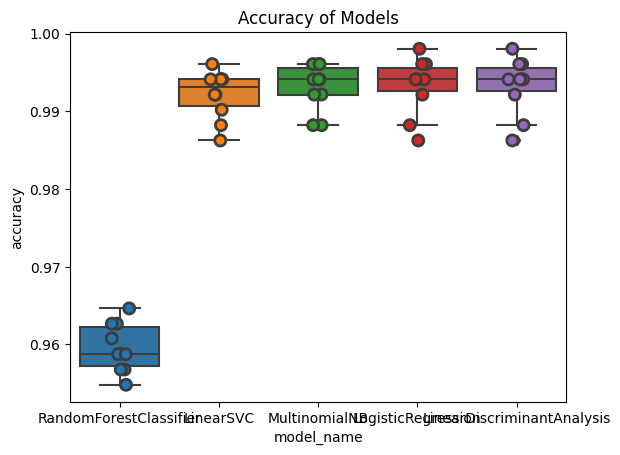

<Figure size 640x480 with 0 Axes>

In [47]:
cv_df = compare_models(X, y, 'Accuracy of Models')

In [49]:
def sample_estimator_sizes(estimator_sizes, X, y):
    estimator_results = []
    for n_estimators in estimator_sizes:
        training_features, test_features, training_target, test_target = train_test_split(X,y,test_size=0.3,random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,test_size = 0.3,random_state=12)
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=0,
            verbose=0,
            class_weight='balanced')
        rf_model = rf_model.fit(X=x_train, y=y_train)
        y_pred = rf_model.predict(x_val)
        accuracy = metrics.accuracy_score(y_val, y_pred)
        precision = metrics.precision_score(y_val, y_pred)
        recall = metrics.recall_score(y_val, y_pred)
        # print('number of estimators: ', n_estimators)
        # print('precision: {}'.format(precision), 'recall: {}'.format(recall), 'accuracy: {}'.format(accuracy))

        kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        results = cross_val_score(rf_model, x_train, y_train,scoring='accuracy', cv=kfold)
        # print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

        results_dict = {'estimator': n_estimators, 'kfold_accuracy': results.mean(), 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1': metrics.f1_score(y_val, y_pred)}
        estimator_results.append(pd.DataFrame([results_dict]))
    estimator_results_df = pd.concat(estimator_results)
    return estimator_results_df

In [50]:
estimator_results_df = sample_estimator_sizes([10, 50, 100, 200, 300, 400, 500], X, y)

In [51]:
estimator_results_df

,estimator,kfold_accuracy,precision,recall,accuracy,f1
0,10,0.995679,0.989362,0.948980,0.997251,0.968750
0,50,0.996268,1.000000,0.959184,0.998168,0.979167
0,100,0.996464,1.000000,0.959184,0.998168,0.979167
0,200,0.996464,1.000000,0.959184,0.998168,0.979167
0,300,0.996464,1.000000,0.959184,0.998168,0.979167
0,400,0.996464,1.000000,0.959184,0.998168,0.979167
0,500,0.996464,1.000000,0.959184,0.998168,0.979167


In [38]:
subset_predictions_df

,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,start_issue,end_issue,datetime,dates,issue_number,...,predicted_issue_number,max_issue_length,token_length,tokenized_text,tokenized_text_length,sentences,sentences_length,issue_size,issue_counts,class_numb
0,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,5439,"[!, €, ‘, §4, *, ', 7¢\, ``, ``, '', ``, '', ....",3229,"[!€‘§4*'7¢\ "" """" """".‘_' """"_""‘ """"__,/ """"‘..'~-....",201,42,45123,0
1,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,54,"[AT, ILLINOIS, LIBRARY, OF, THE, UNIVERSITY, U...",7,[AT ILLINOIS LIBRARY OF THE UNIVERSITY URBANA-...,1,42,45123,0
2,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,404,"[#, ', ``, ,, -, --, -LRB-, -RRB-, ., ..., 0CT...",76,"[# ' '' , - -- -LRB- -RRB- ., ... 0CT 1 11 198...",4,42,45123,0
3,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,2,[~L],1,[~L],1,42,45123,0
4,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1966-04-01,1966-04-01,1966-04-01,April 1966,1.0,...,NaN,0.0,28,"[', ._.____, 1, _, fﬂﬁ, ~, », —-—, », -——]",10,[' ._.____ 1 _ fﬂﬁ ~ »—-—»-——],1,42,45123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,8,"[!, (, 4, I, s]",5,"[!, (4 I s]",2,45,50222,0
1968,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,3,"[I, i]",2,[I i],1,45,50222,0
1969,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,2,[ii],1,[ii],1,45,50222,0
1970,tricontinental,tricontinental_v.1-4(1966-1969),uiug.30112070958894,https://hdl.handle.net/2027/uiug.30112070958894,v.1-4(1966-1969),1969-12-01,1969-12-01,1969-12-01,December 1969,45,...,NaN,0.0,1486,"[!, ``, ``, _, ``, __, ``, ’, ________, “, ', ...",663,"[! "", ""_ ""__ ""’________“ ' '4'_ '5 '_,_ '__ '_...",10,45,50222,0


In [37]:
input_value = combined_df.start_issue.unique().tolist()[0]
most_likely_predicted_issue = combined_df.iloc[(combined_df['predicted_issue_number']-input_value).abs().argsort()[:1]]
top_predictions = predictions[(predictions.max_issue_length == most_likely_predicted_issue.max_issue_length.values[0])]
finalized_issue_length = top_predictions.max_issue_length.unique().tolist()[0]

NameError: name 'predictions' is not defined

In [53]:
def get_finalized_dataset(df, max_issue_length):
    subset_digits = clean_digits(df)
    tqdm.pandas()
    htids = subset_digits.htid.unique().tolist()
    dfs = []
    for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
            subset_df = subset_digits[subset_digits.htid == htid]
            subset_df = get_predicted_page(subset_df, [max_issue_length])
            dfs.append(subset_df)
    combined_subset_digits = pd.concat(dfs)
    combined_subset_digits = combined_subset_digits.reset_index(drop=True)
    digit_cols = combined_subset_digits.columns.tolist()
    digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
    combined_subset_digits = combined_subset_digits[digit_cols]
    cols = list(set(df) & (set(combined_subset_digits)))

    merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
    if merged_df['volume_number'].isna().all():
            merged_df = merged_df.drop(columns='volume_number')
    pages_cols = merged_df.columns.tolist()
    holdout_cols = ['section', 'token', 'pos', 'count', 'number', 'implied_zero']
    pages_cols = [x for x in pages_cols if x not in holdout_cols]
    pages_df = merged_df[pages_cols]
    pages_df = pages_df.drop_duplicates()
    groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
    final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
    final_cols = list(set(pages_df) & set(final_df))
    finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
    return finalized_df

In [99]:
finalized_df = get_finalized_dataset(initial_df, finalized_issue_length)

Processing digits: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


In [100]:
len(initial_df), len(finalized_df)

(363936, 1941)

In [63]:
# Issue size compared to issue tokens
alt.Chart(issues_df).mark_circle().encode(
    x='issue_counts:Q',
    y='issue_size:Q',
    color=alt.Color('year(datetime):O', scale=alt.Scale(scheme='category20b')),
    # color=alt.Color('magazine_title:O', scale=alt.Scale(scheme='category10')),
).properties(
    width=100,
    height=100
).facet(
    facet='cleaned_magazine_title:O',
    # facet='year(datetime):T',
    columns=3
).resolve_scale(x='independent', y='independent')

alt.FacetChart(...)

In [64]:
len(finalized_df[finalized_df.type_of_page == 'content']), len(finalized_df[finalized_df.type_of_page == 'cover_page']), len(finalized_df[finalized_df.type_of_page == 'toc']), len(finalized_df[finalized_df.predicted_page.notna()])

(1864, 40, 35, 77)

In [68]:
len(finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04))

75

In [69]:
content_docs = finalized_df[finalized_df.type_of_page == 'content'].sample(frac=0.04)
cover_docs = finalized_df[finalized_df.type_of_page == 'cover_page']
toc_docs = finalized_df[finalized_df.type_of_page == 'toc']
predicted_docs = finalized_df[finalized_df.predicted_page.notna()]

docs = pd.concat([content_docs, cover_docs, toc_docs, predicted_docs])

In [70]:
remainder_docs = finalized_df[~finalized_df.index.isin(docs.index)]

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer